In [1]:
import os
import time
import math

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import gym

In [3]:
import tensorflow as tf
tf.__version__

'2.0.0-alpha0'

In [4]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, Flatten, LSTM

In [5]:
def create_keras_model(input_shape, n_actions):
    model = keras.Sequential([
        Conv2D(
            filters=32,
            kernel_size=8,
            strides=4,
            activation='relu',
            input_shape=input_shape,
            data_format='channels_last',
        ),
        Conv2D(
            filters=64,
            kernel_size=4,
            strides=2,
            activation='relu',
        ),
        Conv2D(
            filters=64,
            kernel_size=3,
            activation='relu',
        ),
        Flatten(),
        Dense(
            units=n_actions,
        ),
    ])
    
    return model

In [6]:
env_name = 'Breakout-v0'
env = gym.make(env_name)

In [7]:
env.action_space.sample()

3

In [8]:
env.action_space.n

4

In [9]:
env.observation_space.shape

(210, 160, 3)

In [10]:
state = env.reset()
state.shape

(210, 160, 3)

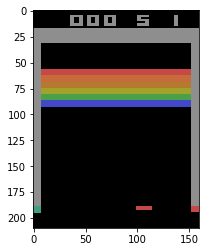

In [11]:
plt.imshow(state)

In [12]:
gray = np.mean(state, axis=2)
gray.shape

(210, 160)

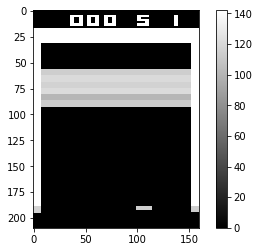

In [13]:
plt.imshow(gray, cmap='gray')
plt.colorbar()

In [14]:
down_sample = gray[::2, ::2]
down_sample.shape

(105, 80)

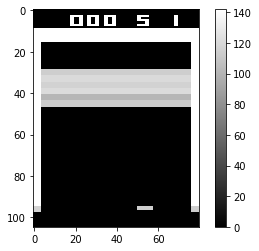

In [15]:
plt.imshow(down_sample, cmap='gray')
plt.colorbar()

In [23]:
def process_image(img):
    _img = np.mean(img, axis=2, dtype=np.uint8)
    _img = _img[::2, ::2]
    return _img

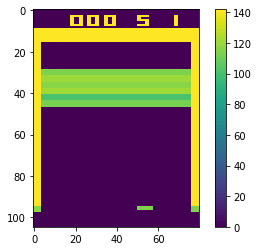

In [18]:
plt.imshow(process_image(state))
plt.colorbar()

In [24]:
_state = process_image(state)
_state.shape

(105, 80)

In [26]:
state.dtype

dtype('uint8')

In [25]:
_state.dtype

dtype('uint8')

In [19]:
state_memory = []

In [103]:
for _ in range(64):
    action = env.action_space.sample()
    observation = env.step(action)
    state, reward, done, info = observation
    _state = process_image(state)
    state_memory.append(_state)

In [28]:
len(state_memory)

64

In [40]:
idx = 0

30


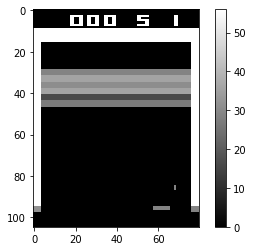

In [74]:
idx %= len(state_memory)
idx += 1
print(idx)
plt.imshow(state_memory[idx], cmap='gray')
plt.colorbar()

In [75]:
seq_states = np.array(state_memory[20:30])
seq_states.shape

(10, 105, 80)

In [76]:
seq_states.dtype

dtype('uint8')

In [77]:
max_seq_states = np.max(seq_states, axis=0)
max_seq_states.shape

(105, 80)

In [78]:
max_seq_states.dtype

dtype('uint8')

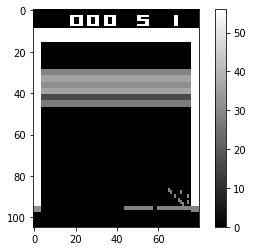

In [82]:
plt.imshow(max_seq_states, cmap='gray')
plt.colorbar()

In [88]:
process_seq_state = []

for idx, s in enumerate(seq_states):
    s = s * (idx / len(seq_states))
#     print(s.shape)
#     print(s.dtype)
    process_seq_state.append(s)
#     break
process_seq_state = np.array(process_seq_state, dtype=np.uint8)
process_seq_state = np.max(process_seq_state, axis=0)

In [85]:
s.shape

(105, 80)

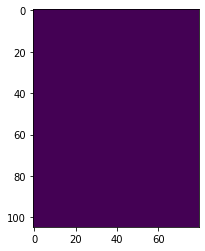

In [86]:
plt.imshow(s)

In [89]:
process_seq_state.shape

(105, 80)

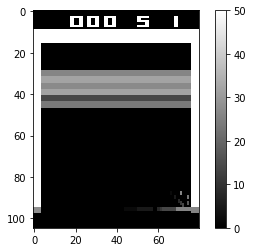

In [91]:
plt.imshow(process_seq_state, cmap='gray')
plt.colorbar()

In [100]:
def ray_trace(seq_images):
    process_seq = []

    for idx, s in enumerate(seq_images):
        s = s * ((idx+1) / len(seq_images))
        process_seq.append(s)
    process_seq = np.array(process_seq, dtype=np.uint8)
    ray_trace_image = np.max(process_seq, axis=0)
    return ray_trace_image

In [112]:
ray_trace_image = ray_trace(state_memory[64:80])
ray_trace_image.shape

(105, 80)

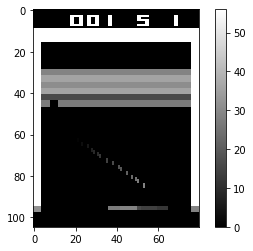

In [113]:
plt.imshow(ray_trace_image, cmap='gray')
plt.colorbar()